# Wczytanie bibliotek:

In [1]:
# pip install torchsummary ultralytics torchviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.8/778.8 kB 27.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [88]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
from time import time
import time
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import LambdaLR
from torchvision.datasets import ImageFolder
from matplotlib.ticker import MaxNLocator
from torch.utils.data import DataLoader, SubsetRandomSampler
from PIL import Image
import matplotlib.image as mpimg
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from torchsummary import summary
from ultralytics import YOLO
from IPython.display import FileLink
from torchviz import make_dot
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
from torch.utils.data import Dataset

# Link do datasetu:

https://www.kaggle.com/datasets/daniildeltsov/traffic-signs-gtsrb-plus-162-custom-classes

# Przygotowanie danych:

Test:

In [18]:
path = r'/kaggle/input/traffic-ds/Data_images'



csv_path = os.path.join(path, 'Test_data.csv')
test_data = pd.read_csv(csv_path)
test_data['Full_path'] = test_data['Path'].apply(lambda x: os.path.join(path, x))

In [22]:
# Definicja ścieżki do pliku CSV
path = r'/kaggle/input/traffic-ds/Data_images'
csv_path = os.path.join(path, 'Test_data.csv')

# Wczytanie danych testowych
test_data = pd.read_csv(csv_path)

# Aktualizacja pełnych ścieżek
test_data['Full_path'] = test_data['Path'].apply(lambda x: os.path.join(path, x))

# Definicja słowników grup i nazw klas
class_group_dict = {
    '0': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '14', '15', '16', '17', '32', '41', '42', '46', '72', '73', '74', '75', '76', '77',
          '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '140', '141',
          '144', '145'],
    '1': ['11', '13', '18', '19', '20', '21', '22', '23', '24', '25', '26', '28', '29', '30', '31', '44', '45', '48', '49', '53', '54', '55',
          '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69'],
    '2': ['12', '27', '43', '47', '110', '111', '112', '113', '114', '115', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126',
          '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '142', '143', '148', '152', '153', '154', '155', '156', '158',
          '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182'],
    '3': ['33', '34', '35', '36', '37', '38', '39', '40', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '146', '147',
          '149', '150', '151'],
    '4': ['50', '51', '52'],
    '5': ['116', '138', '139', '157', '159', '160', '161', '162', '163', '164'],
    '6': ['70', '71', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202',
          '203', '204']
}

class_name_dict = {
    '0': 'prohibition',
    '1': 'warning',
    '2': 'information',
    '3': 'mandatory',
    '4': 'trains',
    '5': 'cities',
    '6': 'supplements'
}

# Tworzenie odwróconego słownika dla szybkiego lookupu
reverse_class_group_dict = {cls: group for group, classes in class_group_dict.items() for cls in classes}

# Mapowanie etykiet klas na ich grupy
test_data['Group'] = test_data['ClassId'].astype(str).map(reverse_class_group_dict)

# Zastąpienie numerów grup nazwami grup
test_data['Group_name'] = test_data['Group'].map(class_name_dict)

In [23]:
test_data

ClassId               Path  \
0          184   Test/184_1_1.png   
1          178  Test/178_6_13.png   
2           61   Test/61_3_18.png   
3           96   Test/96_7_20.png   
4          119  Test/119_1_29.png   
...        ...                ...   
53449      180  Test/180_6_35.png   
53450        4     Test/01147.png   
53451      200  Test/200_3_11.png   
53452       11     Test/12422.png   
53453      181   Test/181_2_4.png   

                                               Full_path Group   Group_name  
0      /kaggle/input/traffic-ds/Data_images/Test/184_...     6  supplements  
1      /kaggle/input/traffic-ds/Data_images/Test/178_...     2  information  
2      /kaggle/input/traffic-ds/Data_images/Test/61_3...     1      warning  
3      /kaggle/input/traffic-ds/Data_images/Test/96_7...     0  prohibition  
4      /kaggle/input/traffic-ds/Data_images/Test/119_...     2  information  
...                                                  ...   ...          ...  
53449  /kaggle/input/traffic-ds/Data_images/Test/180_...     2  information  
53450  /kaggle/input/traffic-ds/Data_images/Test/0114...     0  prohibition  
53451  /kaggle/input/traffic-ds/Data_images/Test/200_...     6  supplements  
53452  /kaggle/input/traffic-ds/Data_images/Test/1242...     1      warning  
53453  /kaggle/input/traffic-ds/Data_images/Test/181_...     2  information  

[53454 rows x 5 columns]

# X_test i y_test:

In [40]:
images_test = test_data['Full_path']
labels_test = test_data['Group']

Train:

In [24]:
train_path = '/kaggle/input/traffic-ds/Data_images/Train'

class_group_dict = {
    '0': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '14', '15', '16', '17', '32', '41', '42', '46', '72', '73', '74', '75', '76', '77',
          '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '140', '141',
          '144', '145'],
    '1': ['11', '13', '18', '19', '20', '21', '22', '23', '24', '25', '26', '28', '29', '30', '31', '44', '45', '48', '49', '53', '54', '55',
          '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69'],
    '2': ['12', '27', '43', '47', '110', '111', '112', '113', '114', '115', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126',
          '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '142', '143', '148', '152', '153', '154', '155', '156', '158',
          '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182'],
    '3': ['33', '34', '35', '36', '37', '38', '39', '40', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '146', '147',
          '149', '150', '151'],
    '4': ['50', '51', '52'],
    '5': ['116', '138', '139', '157', '159', '160', '161', '162', '163', '164'],
    '6': ['70', '71', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202',
          '203', '204']
}

class_name_dict = {
    '0': 'prohibition',
    '1': 'warning',
    '2': 'information',
    '3': 'mandatory',
    '4': 'trains',
    '5': 'cities',
    '6': 'supplements'
}

# Tworzenie odwróconego słownika dla szybkiego lookupu
reverse_class_group_dict = {cls: group for group, classes in class_group_dict.items() for cls in classes}

# Lista do przechowywania informacji o zdjęciach
data = []

# Przechodzenie przez wszystkie foldery w katalogu treningowym
for class_folder in os.listdir(train_path):
    class_folder_path = os.path.join(train_path, class_folder)
    if os.path.isdir(class_folder_path):
        for image_name in os.listdir(class_folder_path):
            if image_name.endswith(('png', 'jpg', 'jpeg')):
                full_path = os.path.join(class_folder_path, image_name)
                class_id = class_folder
                group_id = reverse_class_group_dict.get(class_id, None)
                group_name = class_name_dict.get(group_id, None)
                data.append([full_path, class_id, group_id, group_name])

columns = ['Full_path', 'ClassId', 'Group', 'Group_name']
train_data = pd.DataFrame(data, columns=columns)

In [25]:
train_data

Full_path ClassId Group  \
0      /kaggle/input/traffic-ds/Data_images/Train/7/0...       7     0   
1      /kaggle/input/traffic-ds/Data_images/Train/7/0...       7     0   
2      /kaggle/input/traffic-ds/Data_images/Train/7/0...       7     0   
3      /kaggle/input/traffic-ds/Data_images/Train/7/0...       7     0   
4      /kaggle/input/traffic-ds/Data_images/Train/7/0...       7     0   
...                                                  ...     ...   ...   
97421  /kaggle/input/traffic-ds/Data_images/Train/136...     136     2   
97422  /kaggle/input/traffic-ds/Data_images/Train/136...     136     2   
97423  /kaggle/input/traffic-ds/Data_images/Train/136...     136     2   
97424  /kaggle/input/traffic-ds/Data_images/Train/136...     136     2   
97425  /kaggle/input/traffic-ds/Data_images/Train/136...     136     2   

        Group_name  
0      prohibition  
1      prohibition  
2      prohibition  
3      prohibition  
4      prohibition  
...            ...  
97421  information  
97422  information  
97423  information  
97424  information  
97425  information  

[97426 rows x 4 columns]

# X_train i y_train:

In [30]:
images_train = train_data['Full_path']
labels_train = train_data['Group']

# Przykładowe zdjęcia:

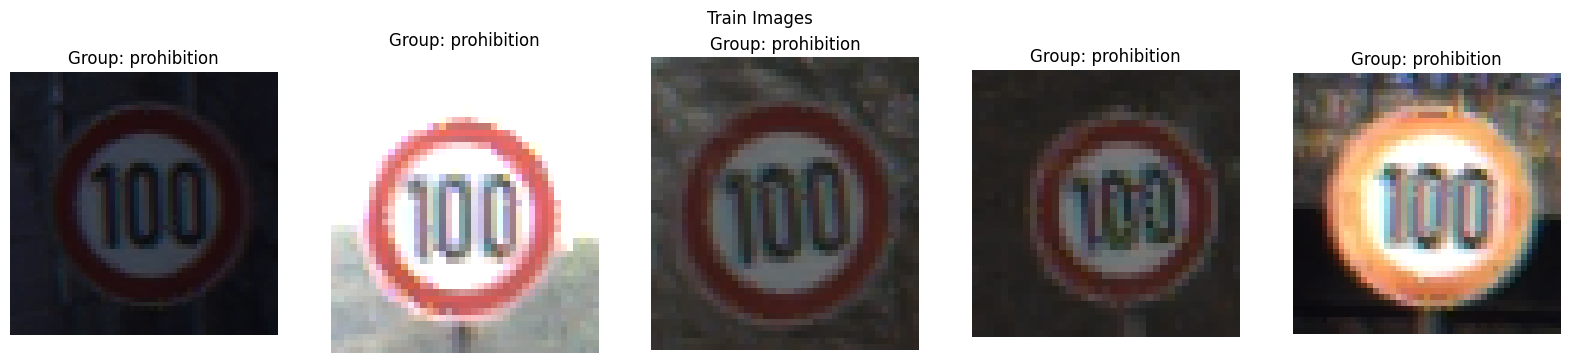

In [37]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, img_path, label in zip(axes, images_train[14:19], labels_train[14:19]):
    img = mpimg.imread(img_path)
    group_name = class_name_dict[str(label)]
    ax.imshow(img)
    ax.set_title(f'Group: {group_name}')
    ax.axis('off')

plt.suptitle('Train Images')
plt.show()

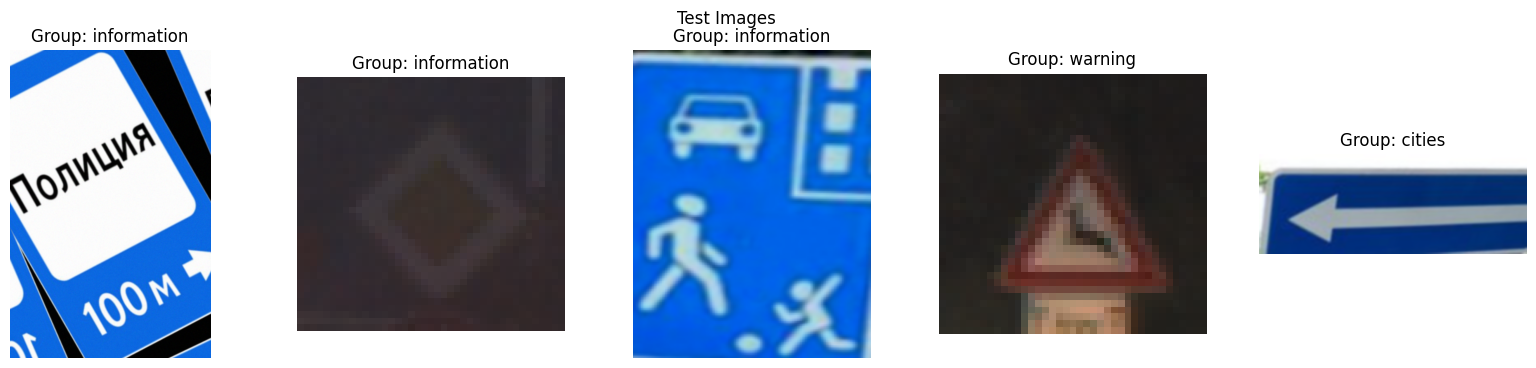

In [45]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, img_path, label in zip(axes, images_test[5:10], labels_test[5:10]):
    img = mpimg.imread(img_path)
    group_name = class_name_dict[str(label)]
    ax.imshow(img)
    ax.set_title(f'Group: {group_name}')
    ax.axis('off')

plt.suptitle('Test Images')
plt.show()


# Ilość zdjęć dla każdej klasy w zbiorze Test:

In [48]:

train_group_counts = labels_train.value_counts().sort_index()

test_group_counts = labels_test.value_counts().sort_index()

print("Liczba zdjęć dla każdej grupy w zbiorze treningowym:\n", train_group_counts)
print("\nLiczba zdjęć dla każdej grupy w zbiorze testowym:\n", test_group_counts)


Liczba zdjęć dla każdej grupy w zbiorze treningowym:
 Group
0    28421
1    17874
2    21302
3    11152
4      807
5     7454
6    10416
Name: count, dtype: int64

Liczba zdjęć dla każdej grupy w zbiorze testowym:
 Group
0    14472
1     8742
2    14862
3     6054
4      756
5     2520
6     6048
Name: count, dtype: int64


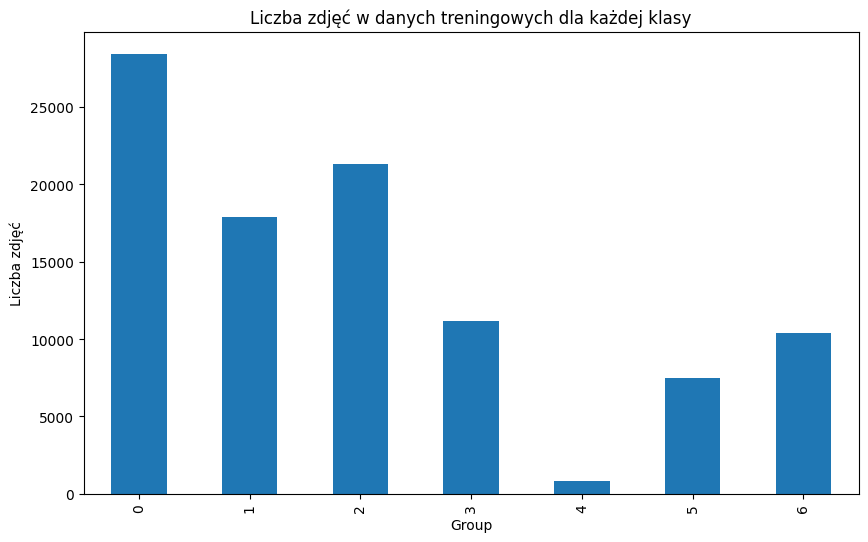

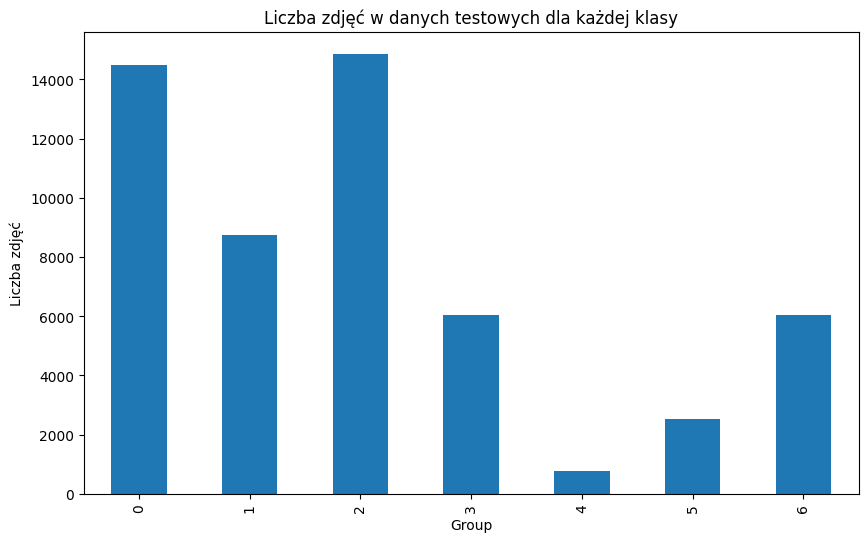

In [52]:
plt.figure(figsize=(10, 6))
train_group_counts.plot(kind='bar')
plt.title('Liczba zdjęć w danych treningowych dla każdej klasy')
plt.xlabel('Group')
plt.ylabel('Liczba zdjęć')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
test_group_counts.plot(kind='bar')
plt.title('Liczba zdjęć w danych testowych dla każdej klasy')
plt.xlabel('Group')
plt.ylabel('Liczba zdjęć')
plt.xticks(rotation=90)
plt.show()


# Równoważenie zbiorów:

In [57]:
train_data = train_data[train_data['Group'] != '4']

train_sampled = train_data.groupby('Group').apply(lambda x: x.sample(n=7000, random_state=42)).reset_index(drop=True)

test_data = test_data[test_data['Group'] != '4']

test_sampled = test_data.groupby('Group').apply(lambda x: x.sample(n=1000, random_state=42)).reset_index(drop=True)

train_group_counts = train_sampled['Group_name'].value_counts().sort_index()

test_group_counts = test_sampled['Group_name'].value_counts().sort_index()

print("Liczba zdjęć dla każdej grupy w zbiorze treningowym:\n", train_group_counts)
print("\nLiczba zdjęć dla każdej grupy w zbiorze testowym:\n", test_group_counts)


Liczba zdjęć dla każdej grupy w zbiorze treningowym:
 Group_name
cities         7000
information    7000
mandatory      7000
prohibition    7000
supplements    7000
warning        7000
Name: count, dtype: int64

Liczba zdjęć dla każdej grupy w zbiorze testowym:
 Group_name
cities         1000
information    1000
mandatory      1000
prohibition    1000
supplements    1000
warning        1000
Name: count, dtype: int64


/tmp/ipykernel_34/4094766067.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_sampled = train_data.groupby('Group').apply(lambda x: x.sample(n=7000, random_state=42)).reset_index(drop=True)
/tmp/ipykernel_34/4094766067.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_sampled = test_data.groupby('Group').apply(lambda x: x.sample(n=1000, random_state=42)).reset_index(drop=True)


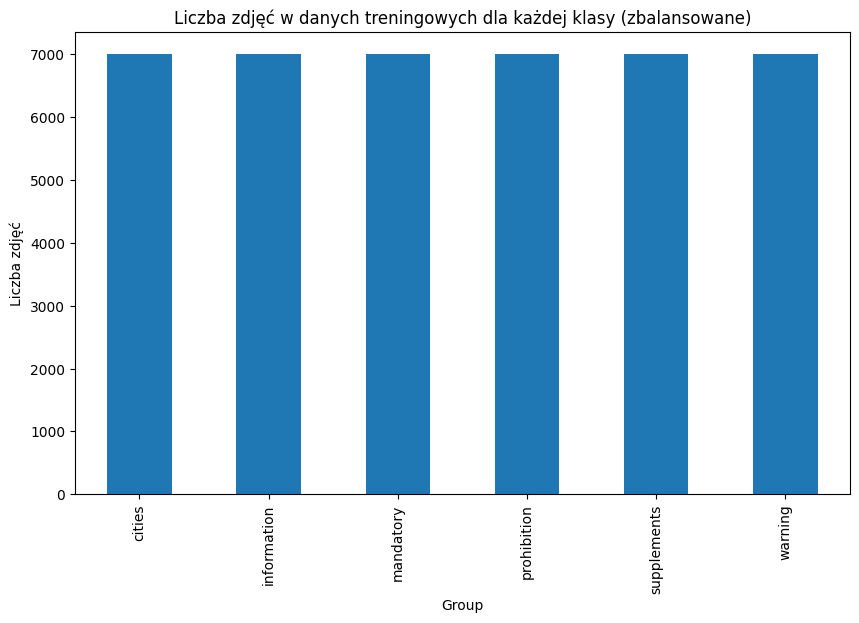

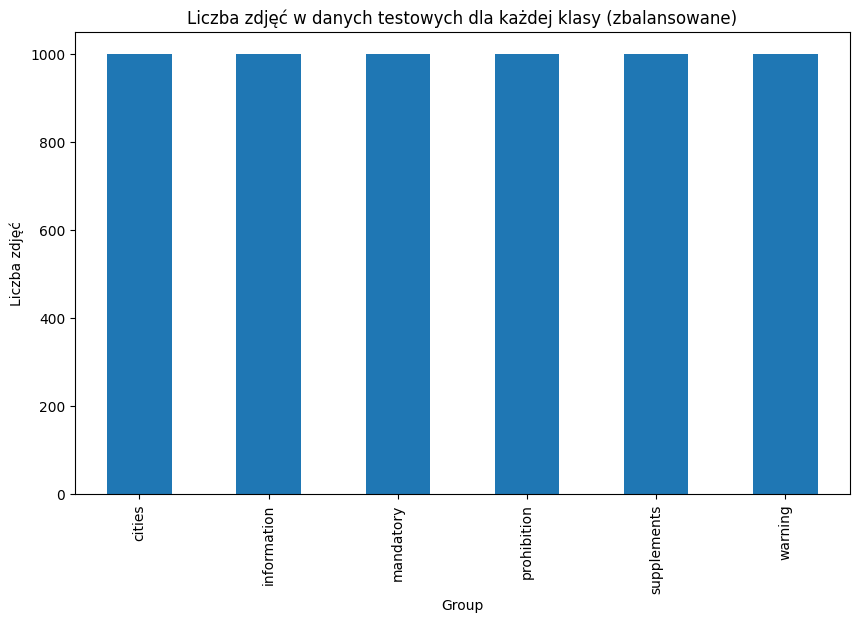

In [58]:
plt.figure(figsize=(10, 6))
train_group_counts.plot(kind='bar')
plt.title('Liczba zdjęć w danych treningowych dla każdej klasy (zbalansowane)')
plt.xlabel('Group')
plt.ylabel('Liczba zdjęć')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
test_group_counts.plot(kind='bar')
plt.title('Liczba zdjęć w danych testowych dla każdej klasy (zbalansowane)')
plt.xlabel('Group')
plt.ylabel('Liczba zdjęć')
plt.xticks(rotation=90)
plt.show()


# Transformacja zdjęć i normalizacja:

In [60]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Funkcja do załadowania i przekształcenia obrazu
def load_and_transform_image(img_path):
    image = Image.open(img_path).convert('RGB')
    return transform(image)

# Transformowanie obrazów treningowych
train_images_transformed = [load_and_transform_image(img_path) for img_path in train_sampled['Full_path']]
train_labels = train_sampled['Group'].astype(int).tolist()

# Transformowanie obrazów testowych
test_images_transformed = [load_and_transform_image(img_path) for img_path in test_sampled['Full_path']]
test_labels = test_sampled['Group'].astype(int).tolist()

# Konwertowanie list na tensory
train_images_tensor = torch.stack(train_images_transformed)
train_labels_tensor = torch.tensor(train_labels)

test_images_tensor = torch.stack(test_images_transformed)
test_labels_tensor = torch.tensor(test_labels)

print(f'Liczba klas: {len(train_data["Group"].unique())}')
print(f'Liczba próbek treningowych: {train_images_tensor.shape[0]}')
print(f'Liczba próbek testowych: {test_images_tensor.shape[0]}')

Liczba klas: 6
Liczba próbek treningowych: 42000
Liczba próbek testowych: 6000


# Funkcja do pomiaru czasu trwania treningu

In [61]:
def measure_training_time(model, criterion, optimizer, train_loader, test_loader, device, epochs=5):
    start_time = time()
    history, report = train_and_evaluate(model, criterion, optimizer, train_loader, test_loader, device, epochs)
    end_time = time()
    training_time = end_time - start_time
    return history, report, training_time

# ResNet18

In [74]:
def train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, device, epochs, patience):
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    early_stopping = EarlyStopping(patience=patience, delta=0.01)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_acc = correct / total
        train_loss = running_loss / len(train_loader)
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        val_loss = running_loss / len(val_loader)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        early_stopping(val_acc, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    return history, early_stopping.best_val_acc


# Trenowanie modelu z kroswalidacją:

In [76]:
class DatasetFromTensors(Dataset):
    def __init__(self, images_tensor, labels_tensor):
        self.images_tensor = images_tensor
        self.labels_tensor = labels_tensor

    def __len__(self):
        return len(self.labels_tensor)

    def __getitem__(self, idx):
        return self.images_tensor[idx], self.labels_tensor[idx]

k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
resnet_histories = []
resnet_times = []

print("Training ResNet18 model...")
epochs = 50 
patience = 3  

labels = np.array(train_sampled['Group'].astype(int))

for fold, (train_index, val_index) in enumerate(kf.split(np.zeros(len(labels)), labels), 1):
    print(f"Fold {fold}/{k}")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    # Stworzenie DataLoaderów dla bieżącego folda
    train_loader = DataLoader(DatasetFromTensors(train_images_tensor, train_labels_tensor), batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(DatasetFromTensors(train_images_tensor, train_labels_tensor), batch_size=32, sampler=val_sampler)

    model = ResNet18Model(num_classes=len(class_name_dict)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start_time = time.time()
    history, best_val_acc = train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, device, epochs, patience)
    end_time = time.time()
    
    resnet_histories.append(history)
    resnet_times.append(end_time - start_time)
    
    print(f"Best validation accuracy for fold {fold}: {best_val_acc:.4f}")

print("Training completed for ResNet18 model with early stopping.")


Training ResNet18 model...
Fold 1/5
Epoch 1/50 - Train Acc: 0.8188, Val Acc: 0.9376, Train Loss: 0.4872, Val Loss: 0.1914
Epoch 2/50 - Train Acc: 0.9561, Val Acc: 0.9664, Train Loss: 0.1306, Val Loss: 0.0990
Epoch 3/50 - Train Acc: 0.9752, Val Acc: 0.9774, Train Loss: 0.0784, Val Loss: 0.0674
Epoch 4/50 - Train Acc: 0.9810, Val Acc: 0.9746, Train Loss: 0.0565, Val Loss: 0.0886
Epoch 5/50 - Train Acc: 0.9864, Val Acc: 0.9789, Train Loss: 0.0426, Val Loss: 0.0718
Epoch 6/50 - Train Acc: 0.9891, Val Acc: 0.9849, Train Loss: 0.0333, Val Loss: 0.0494
Early stopping
Best validation accuracy for fold 1: 0.9774
Fold 2/5
Epoch 1/50 - Train Acc: 0.8264, Val Acc: 0.9294, Train Loss: 0.4771, Val Loss: 0.2057
Epoch 2/50 - Train Acc: 0.9553, Val Acc: 0.9677, Train Loss: 0.1373, Val Loss: 0.0939
Epoch 3/50 - Train Acc: 0.9750, Val Acc: 0.9783, Train Loss: 0.0762, Val Loss: 0.0622
Epoch 4/50 - Train Acc: 0.9818, Val Acc: 0.9808, Train Loss: 0.0559, Val Loss: 0.0606
Epoch 5/50 - Train Acc: 0.9860, Val 

 Hiperparametry:

* Learning Rate (lr): 0.001
* Epochs: 50
* Batch Size: 64
* Optimizer: Adam
* Loss Function: CrossEntropyLoss
* Patience: 3 (Early Stopping)

Cross-Walidacja: K=5

Early Stopping: Mechanizm zatrzymujący trening, jeśli model przestaje się poprawiać na zbiorze walidacyjnym przez określoną liczbę epok (patience).

Cross-Walidacja (k=5): Podział danych na 5 równych części (foldów) w celu walidacji modelu. Model jest trenowany pięciokrotnie, za każdym razem używając innego folda jako zbioru walidacyjnego, a pozostałych foldów jako zbioru treningowego. Pomaga to w ocenie stabilności modelu i jego wydajności na nieznanych danych.

# Krzywe uczenia:

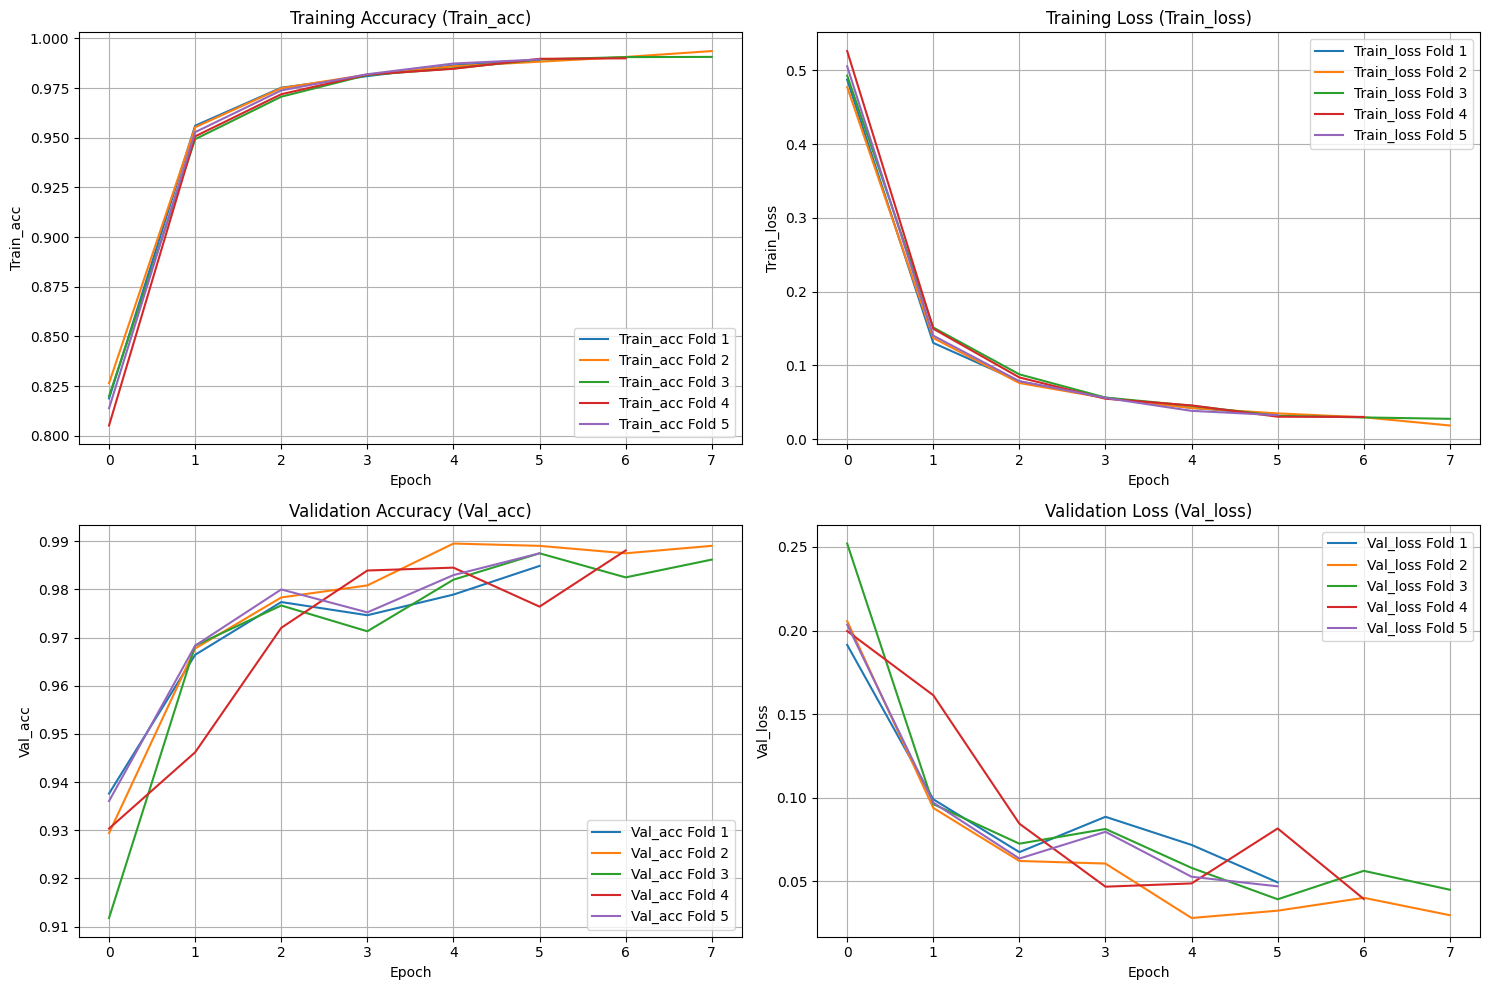

In [78]:
def plot_learning_curves(histories, metrics, titles):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for ax, metric, title in zip(axes, metrics, titles):
        for fold, history in enumerate(histories, 1):
            if metric in history:
                ax.plot(history[metric], label=f'{metric.capitalize()} Fold {fold}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{title} ({metric.capitalize()})')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    
metrics = ['train_acc', 'train_loss', 'val_acc', 'val_loss']
titles = ['Training Accuracy', 'Training Loss', 'Validation Accuracy', 'Validation Loss']

plot_learning_curves(resnet_histories, metrics, titles)


# Ocena modelu na zbiorze testowym:

Test Accuracy: 0.9280, Test Loss: 0.2325


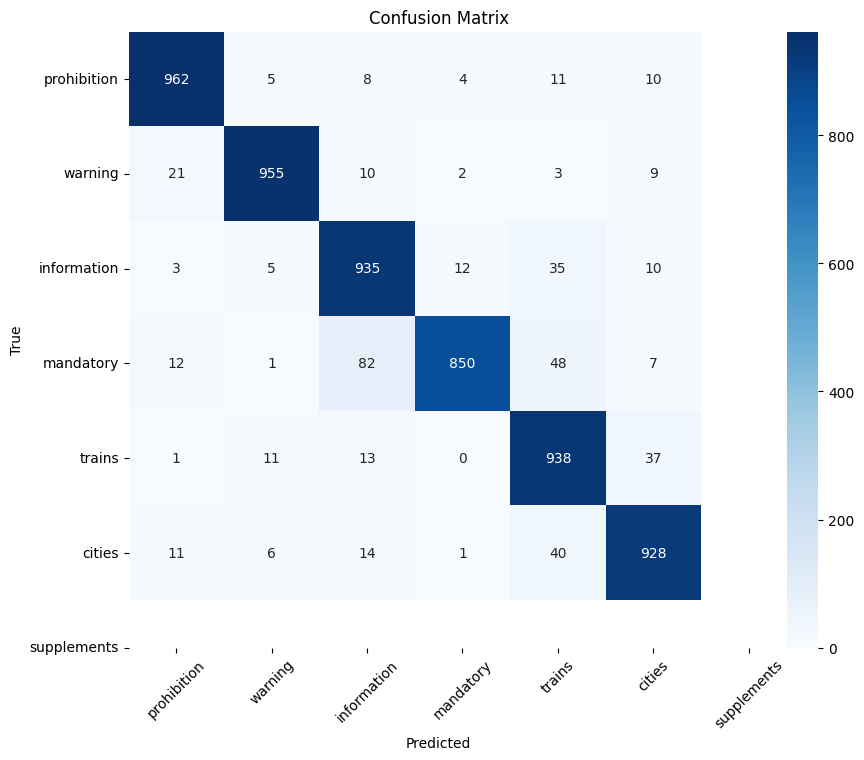

In [85]:
# Funkcja do oceny modelu na zbiorze testowym i obliczania macierzy pomyłek
def evaluate_on_test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    test_acc = correct / total
    test_loss = running_loss / len(test_loader)
    
    # Obliczanie macierzy pomyłek
    cm = confusion_matrix(all_labels, all_predictions)
    
    return test_acc, test_loss, cm

# Tworzenie DataLoadera dla zbioru testowego
test_loader = DataLoader(DatasetFromTensors(test_images_tensor, test_labels_tensor), batch_size=32, shuffle=False)

# Załadowanie najlepszego modelu
best_model = ResNet18Model(num_classes=len(class_name_dict)).to(device)
best_model.load_state_dict(torch.load('checkpoint_ResNet18.pt'))

# Ocena modelu na zbiorze testowym
test_acc, test_loss, cm = evaluate_on_test(best_model, test_loader, device)
print(f'Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

# Wyświetlenie macierzy pomyłek za pomocą seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_name_dict[str(i)] for i in range(len(class_name_dict))], yticklabels=[class_name_dict[str(i)] for i in range(len(class_name_dict))])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


Summary for ResNet18
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-

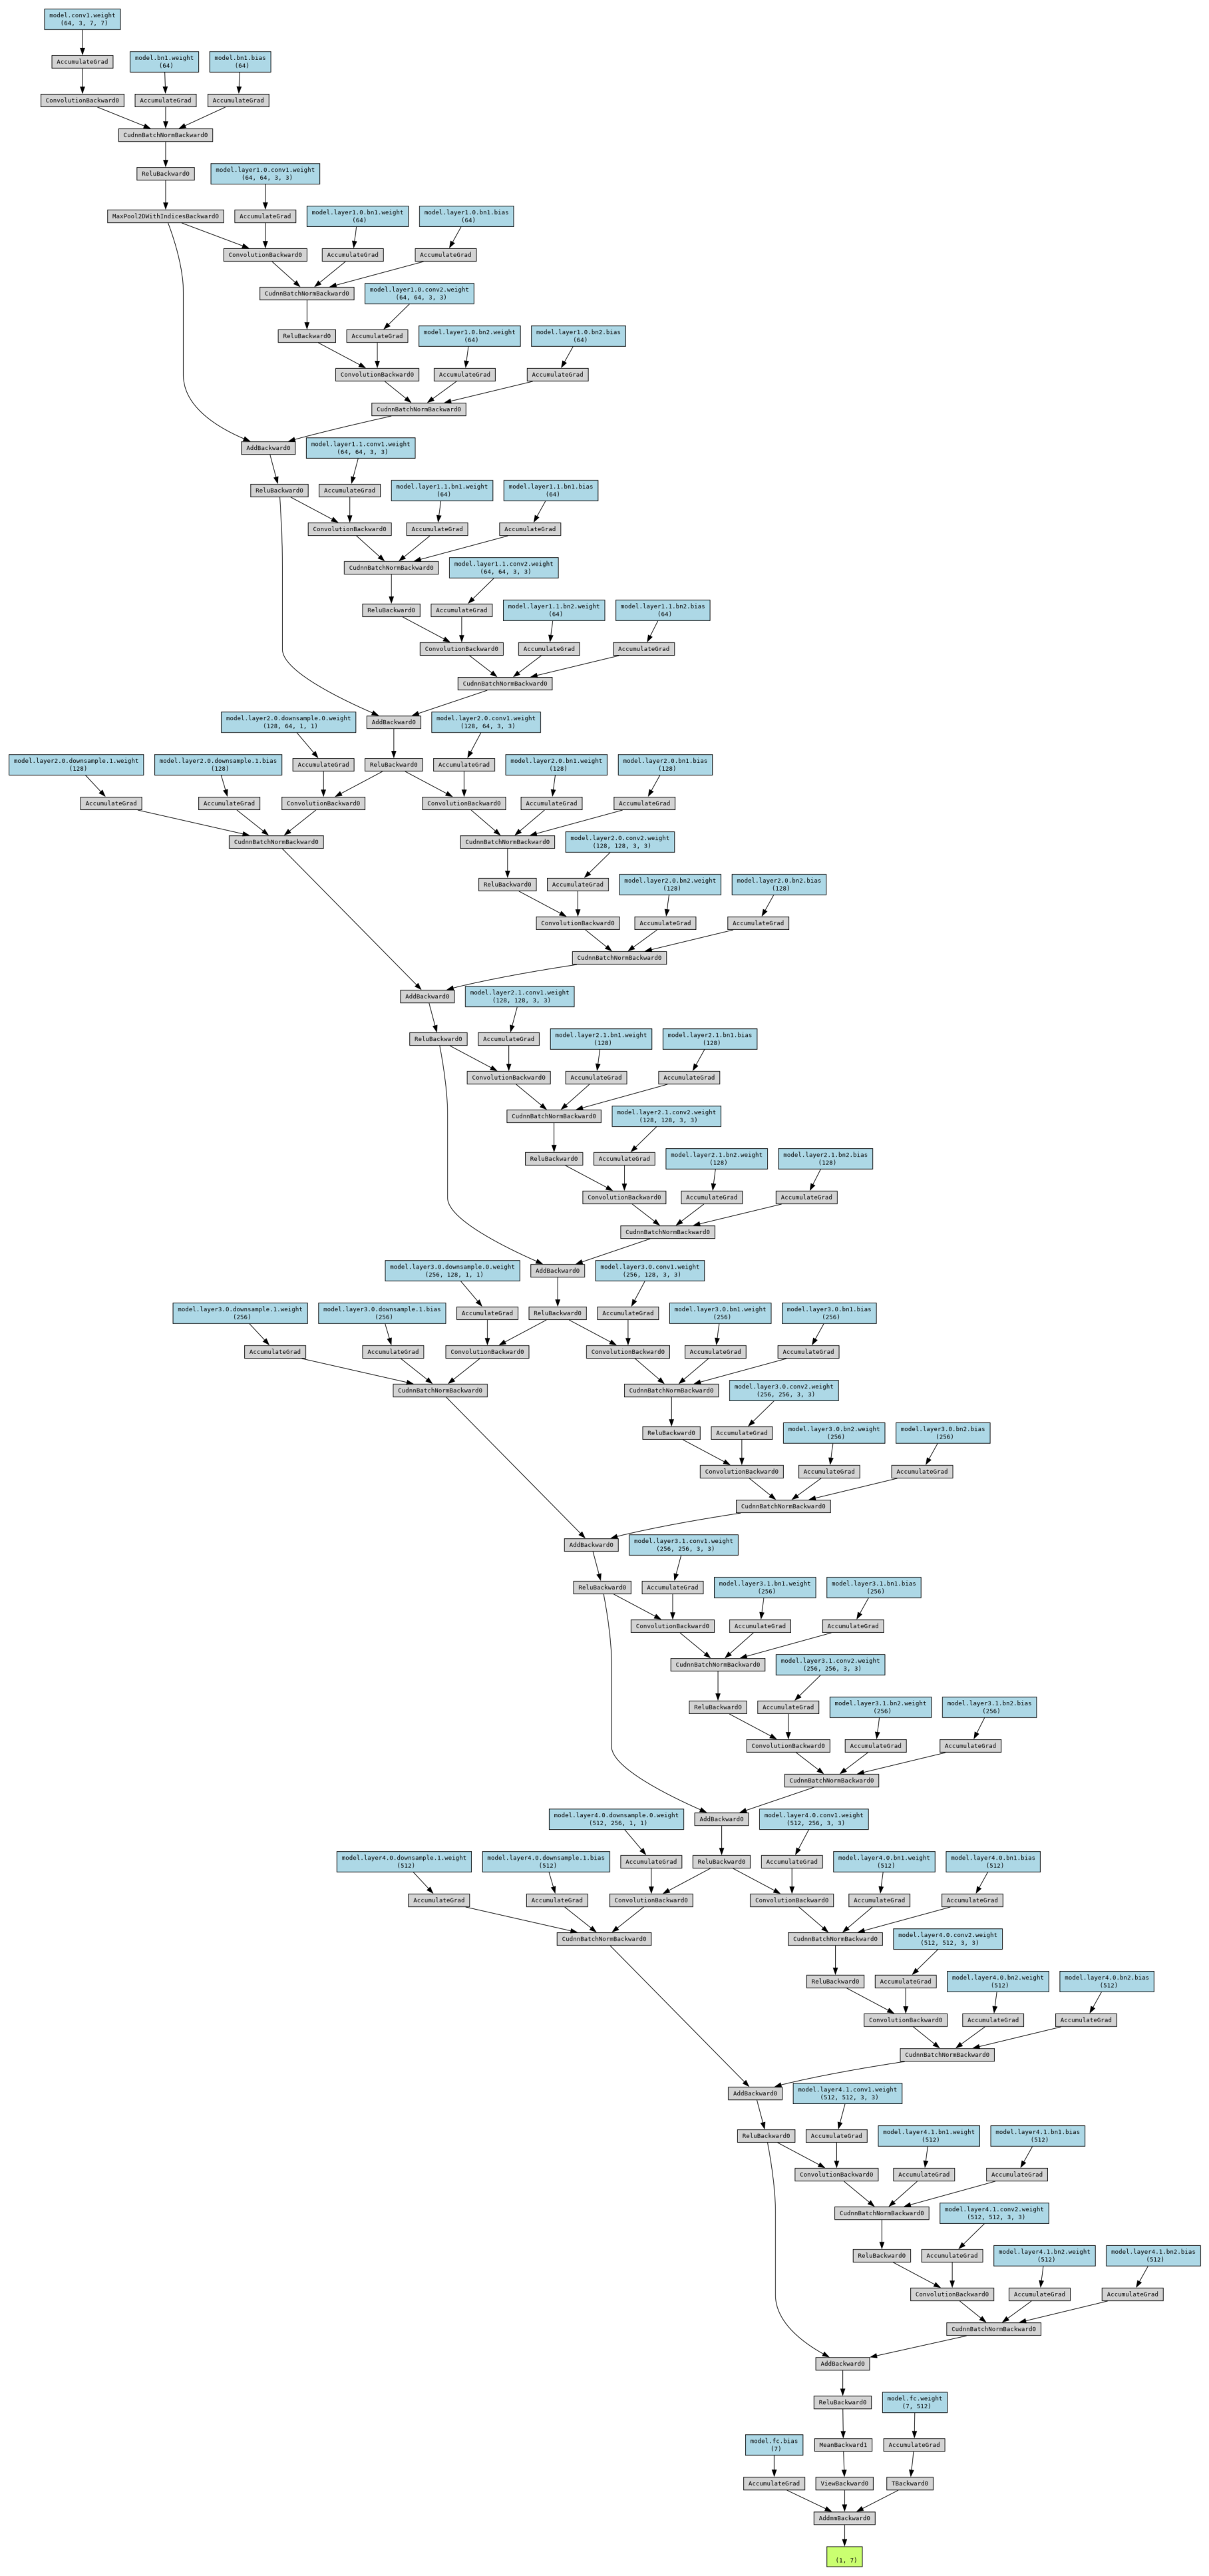

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_name_dict)

# Definicja modelu ResNet18
class ResNet18Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18Model, self).__init__()
        self.model = models.resnet18(weights=None)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Inicjalizacja modelu
resnet_model = ResNet18Model(num_classes=num_classes).to(device)

# Wygenerowanie podsumowania modelu
print("Summary for ResNet18")
summary(resnet_model, input_size=(3, 128, 128))

# Przykładowe dane wejściowe
x = torch.randn(1, 3, 128, 128).to(device)

# Forward pass przez model
y = resnet_model(x)

# Wizualizacja modelu w większym rozmiarze
make_dot(y, params=dict(resnet_model.named_parameters())).render("resnet18_model_large", format="png")

# Wyświetlenie obrazu schematu modelu w większym rozmiarze
image = Image.open("resnet18_model_large.png")
plt.figure(figsize=(50, 50))  # Zmienione na większy rozmiar
plt.imshow(image)
plt.axis('off')
plt.show()

# VGG16

Summary for VGG16
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14 

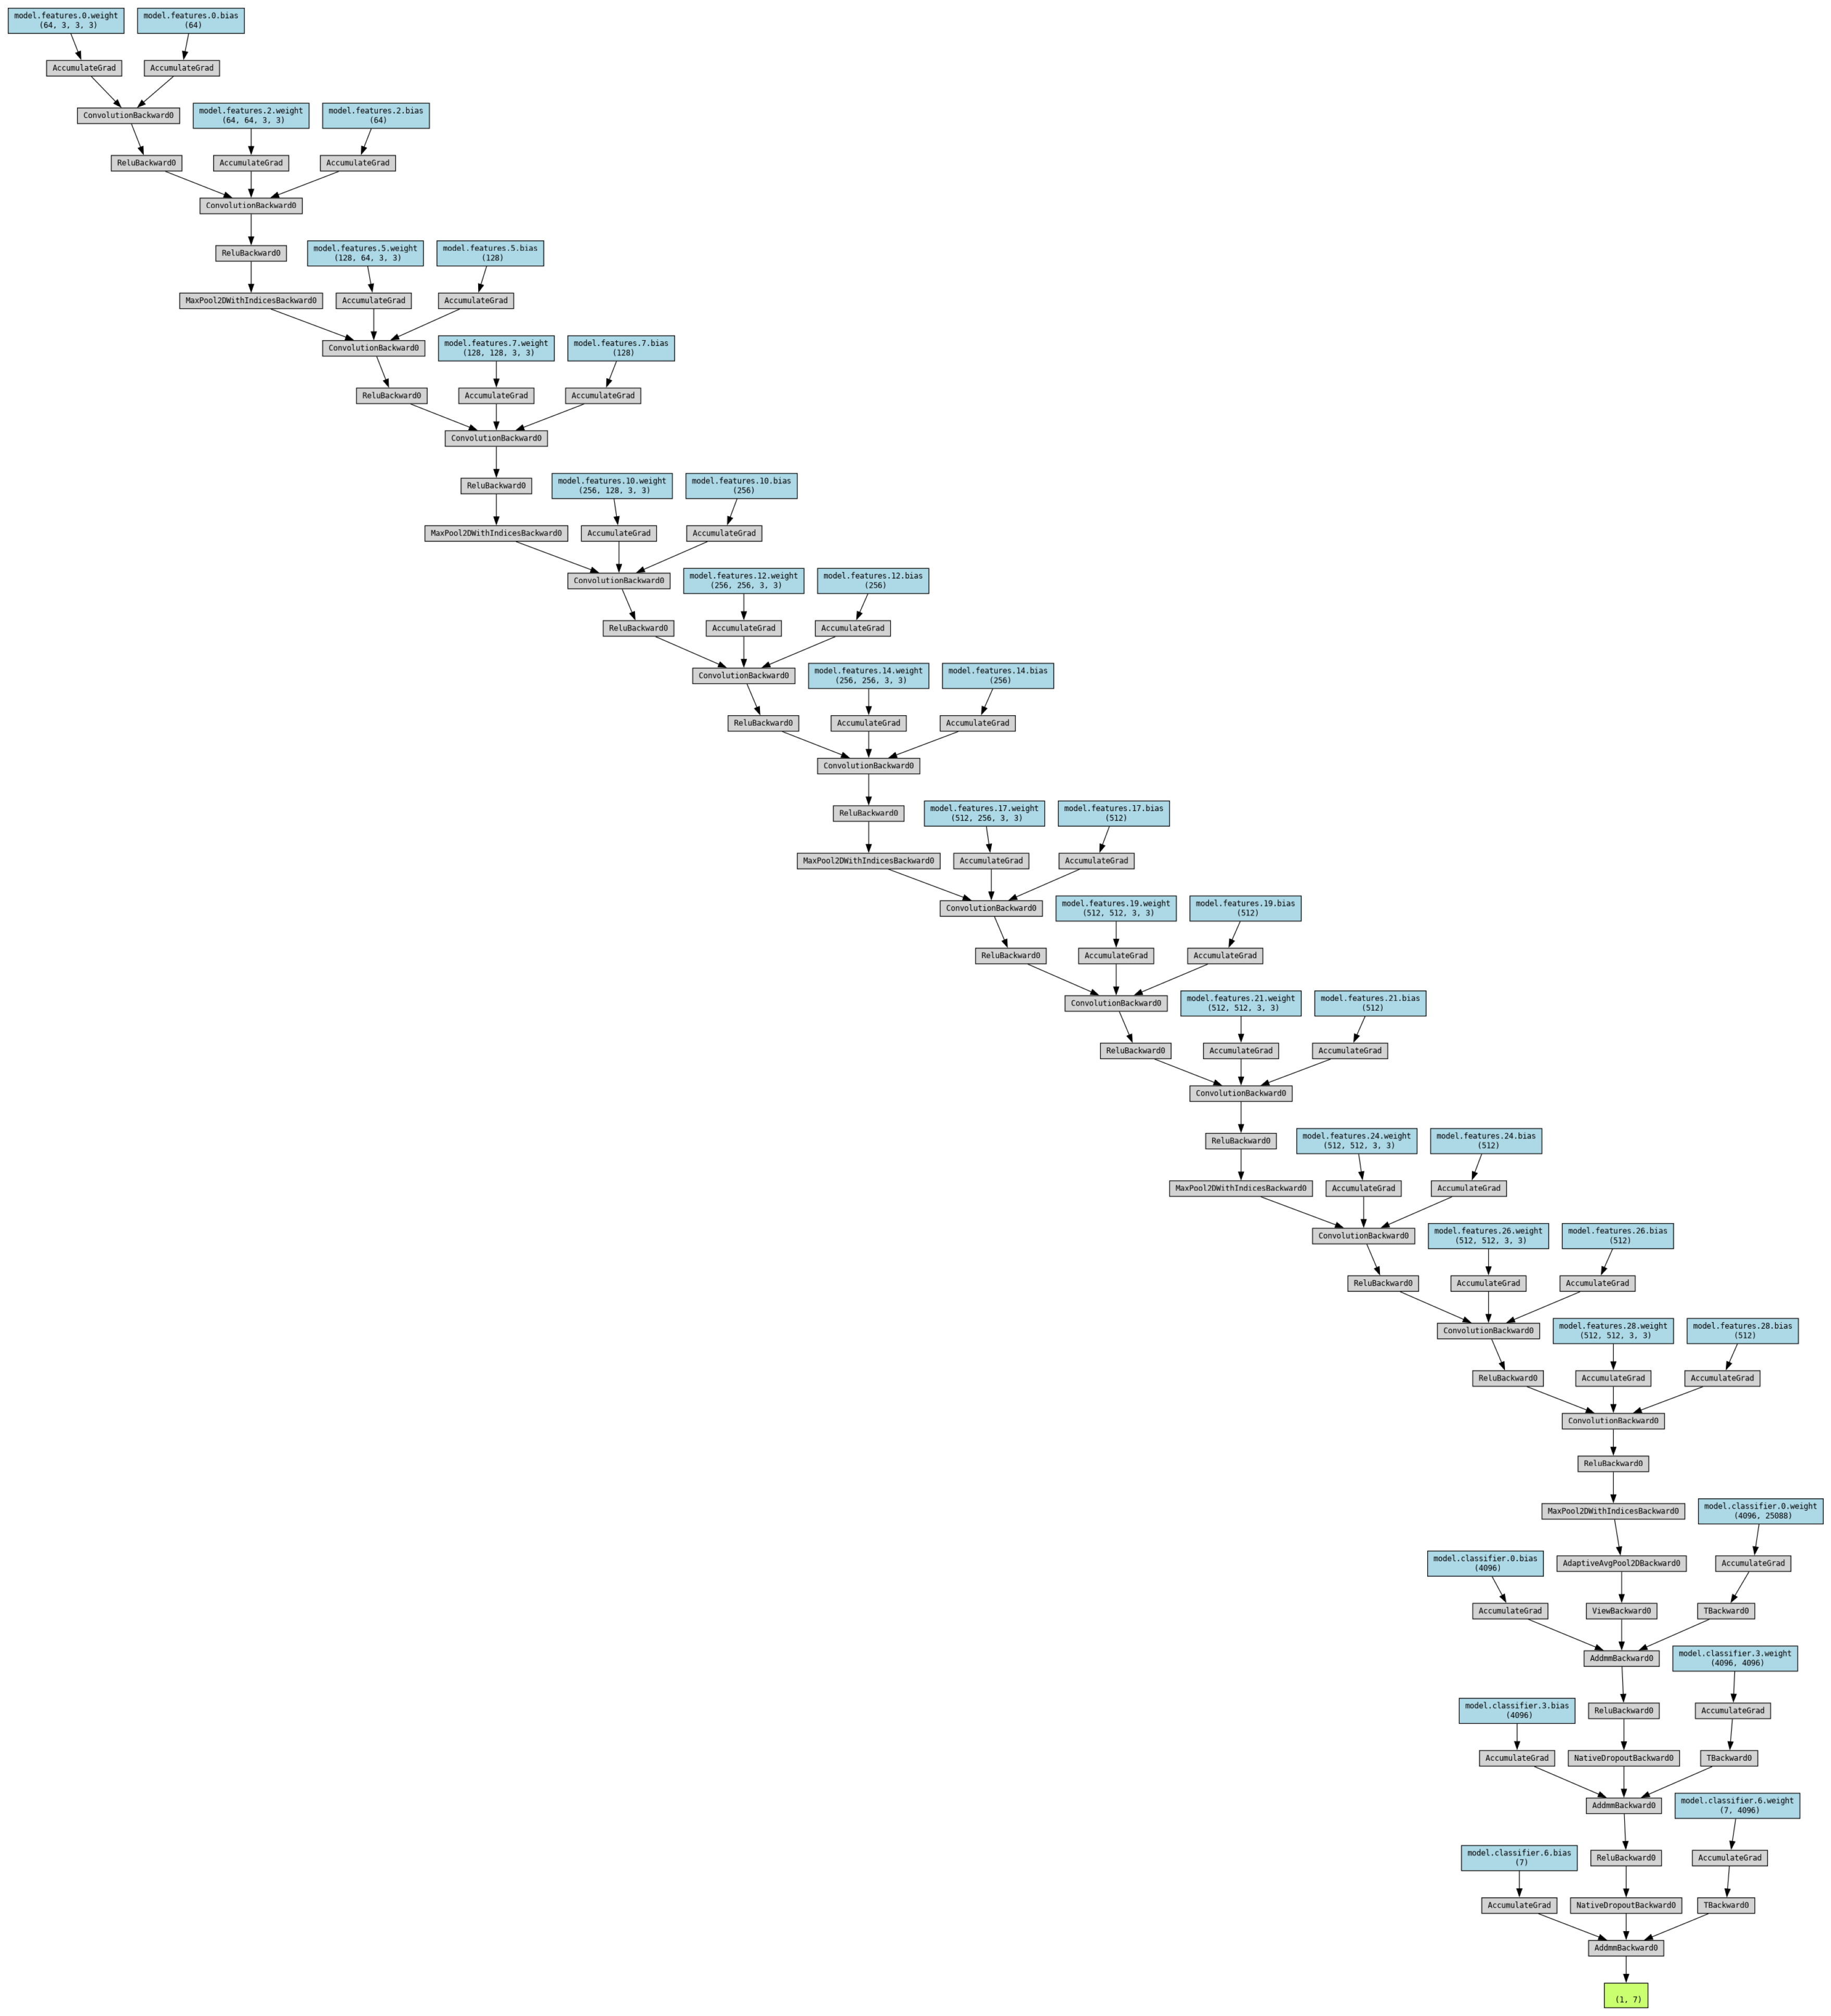

In [94]:
import torch
import torch.nn as nn
from torchvision import models
from torchsummary import summary
from torchviz import make_dot
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_name_dict)

# Definicja modelu VGG16
class VGG16Model(nn.Module):
    def __init__(self, num_classes):
        super(VGG16Model, self).__init__()
        self.model = models.vgg16(weights=None)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Inicjalizacja modelu
vgg16_model = VGG16Model(num_classes=num_classes).to(device)

# Wygenerowanie podsumowania modelu
print("Summary for VGG16")
summary(vgg16_model, input_size=(3, 128, 128))

# Przykładowe dane wejściowe
x = torch.randn(1, 3, 128, 128).to(device)

# Forward pass przez model
y = vgg16_model(x)

# Wizualizacja modelu w większym rozmiarze
make_dot(y, params=dict(vgg16_model.named_parameters())).render("vgg16_model_large", format="png")

# Wyświetlenie obrazu schematu modelu w większym rozmiarze
image = Image.open("vgg16_model_large.png")
plt.figure(figsize=(50, 50))  # Zmienione na większy rozmiar
plt.imshow(image)
plt.axis('off')
plt.show()


In [102]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_val_acc = 0

    def __call__(self, val_acc, model, path='checkpoint_vgg16.pt'):
        if self.best_score is None:
            self.best_score = val_acc
            self.save_checkpoint(val_acc, model, path)
        elif val_acc < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.save_checkpoint(val_acc, model, path)
            self.counter = 0

    def save_checkpoint(self, val_acc, model, path):
        self.best_val_acc = val_acc
        torch.save(model.state_dict(), path)

def train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, device, epochs, patience):
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    early_stopping = EarlyStopping(patience=patience, delta=0.01)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_acc = correct / total
        train_loss = running_loss / len(train_loader)
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        val_loss = running_loss / len(val_loader)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        early_stopping(val_acc, model, path='checkpoint_vgg16.pt')

        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    return history, early_stopping.best_val_acc

# Tworzenie DataLoadera dla zbioru testowego
test_loader = DataLoader(DatasetFromTensors(test_images_tensor, test_labels_tensor), batch_size=32, shuffle=False)

# Kroswalidacja i trening modelu VGG16
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
vgg16_histories = []
vgg16_times = []

print("Training VGG16 model...")
epochs = 50 
patience = 3  

labels = np.array(train_sampled['Group'].astype(int))

for fold, (train_index, val_index) in enumerate(kf.split(np.zeros(len(labels)), labels), 1):
    print(f"Fold {fold}/{k}")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    # Stworzenie DataLoaderów dla bieżącego folda
    train_loader = DataLoader(DatasetFromTensors(train_images_tensor, train_labels_tensor), batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(DatasetFromTensors(train_images_tensor, train_labels_tensor), batch_size=32, sampler=val_sampler)

    model = VGG16Model(num_classes=len(class_name_dict)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Zmieniony współczynnik uczenia

    start_time = time.time()
    history, best_val_acc = train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, device, epochs, patience)
    end_time = time.time()
    
    vgg16_histories.append(history)
    vgg16_times.append(end_time - start_time)
    
    print(f"Best validation accuracy for fold {fold}: {best_val_acc:.4f}")

print("Training completed for VGG16 model with early stopping.")


Training VGG16 model...
Fold 1/5
Epoch 1/50 - Train Acc: 0.7784, Val Acc: 0.9244, Train Loss: 0.5811, Val Loss: 0.2302
Epoch 2/50 - Train Acc: 0.9525, Val Acc: 0.9706, Train Loss: 0.1502, Val Loss: 0.1073
Epoch 3/50 - Train Acc: 0.9748, Val Acc: 0.9693, Train Loss: 0.0830, Val Loss: 0.0942
Epoch 4/50 - Train Acc: 0.9843, Val Acc: 0.9857, Train Loss: 0.0544, Val Loss: 0.0536
Epoch 5/50 - Train Acc: 0.9851, Val Acc: 0.9892, Train Loss: 0.0509, Val Loss: 0.0381
Epoch 6/50 - Train Acc: 0.9912, Val Acc: 0.9850, Train Loss: 0.0309, Val Loss: 0.0590
Epoch 7/50 - Train Acc: 0.9913, Val Acc: 0.9749, Train Loss: 0.0296, Val Loss: 0.1660
Early stopping
Best validation accuracy for fold 1: 0.9857
Fold 2/5
Epoch 1/50 - Train Acc: 0.7824, Val Acc: 0.9445, Train Loss: 0.5727, Val Loss: 0.1680
Epoch 2/50 - Train Acc: 0.9504, Val Acc: 0.9676, Train Loss: 0.1538, Val Loss: 0.0908
Epoch 3/50 - Train Acc: 0.9757, Val Acc: 0.9729, Train Loss: 0.0821, Val Loss: 0.0888
Epoch 4/50 - Train Acc: 0.9832, Val Acc

Hiperparametry:

* Learning Rate (lr): 0.0001
* Epochs: 50
* Batch Size: 64
* Optimizer: Adam
* Loss Function: CrossEntropyLoss
* Patience: 3 (Early Stopping)

Cross-Walidacja: K=5

Early Stopping: Mechanizm zatrzymujący trening, jeśli model przestaje się poprawiać na zbiorze walidacyjnym przez określoną liczbę epok (patience).

Cross-Walidacja (k=5): Podział danych na 5 równych części (foldów) w celu walidacji modelu. Model jest trenowany pięciokrotnie, za każdym razem używając innego folda jako zbioru walidacyjnego, a pozostałych foldów jako zbioru treningowego. Pomaga to w ocenie stabilności modelu i jego wydajności na nieznanych danych.

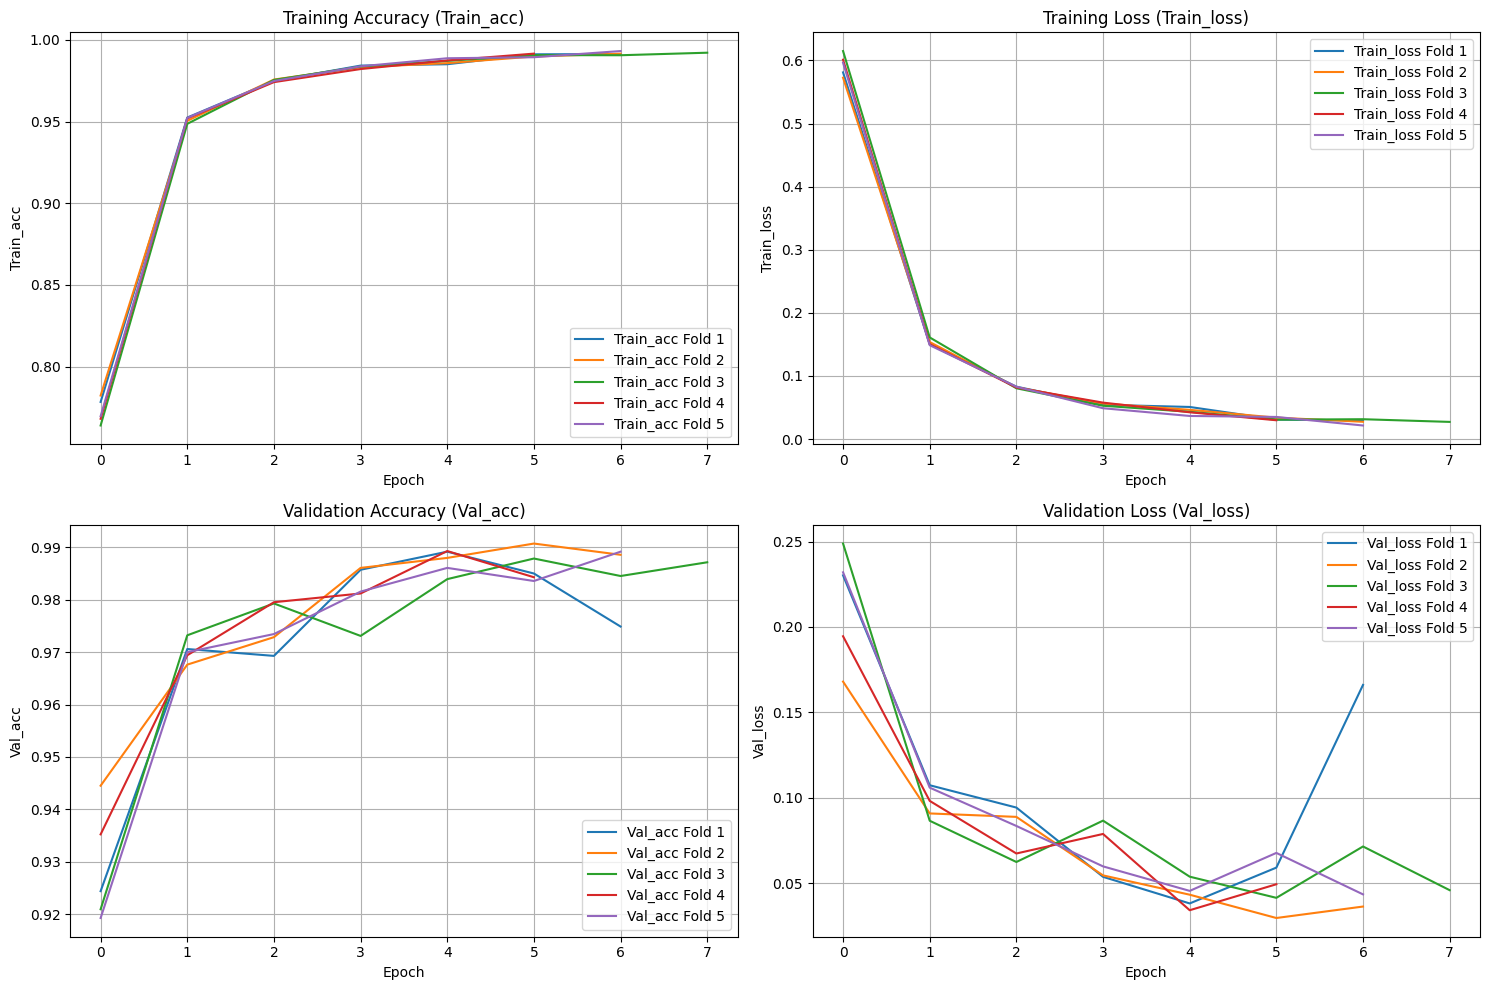

In [108]:
import matplotlib.pyplot as plt

def plot_learning_curves(histories, metrics, titles):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for ax, metric, title in zip(axes, metrics, titles):
        for fold, history in enumerate(histories, 1):
            if metric in history:
                ax.plot(history[metric], label=f'{metric.capitalize()} Fold {fold}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{title} ({metric.capitalize()})')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Definicje metryk i tytułów
metrics = ['train_acc', 'train_loss', 'val_acc', 'val_loss']
titles = ['Training Accuracy', 'Training Loss', 'Validation Accuracy', 'Validation Loss']

# Wywołanie funkcji plot_learning_curves dla VGG16
plot_learning_curves(vgg16_histories, metrics, titles)


Test Accuracy: 0.9343, Test Loss: 0.2238


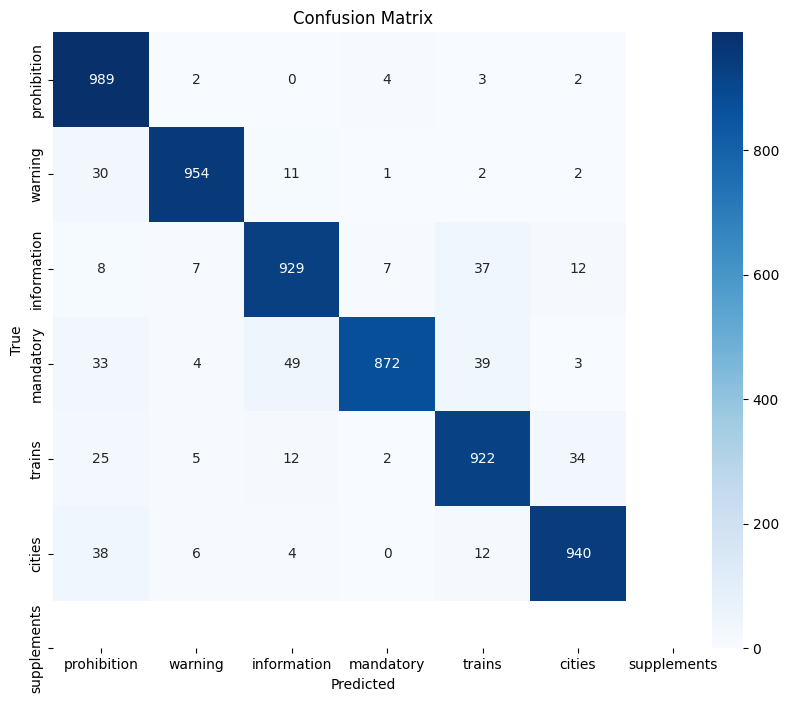

In [105]:
def evaluate_on_test(model, criterion, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    test_acc = correct / total
    test_loss = running_loss / len(test_loader)
    
    cm = confusion_matrix(all_labels, all_predictions)
    
    return test_acc, test_loss, cm

# Tworzenie DataLoadera dla zbioru testowego
test_loader = DataLoader(DatasetFromTensors(test_images_tensor, test_labels_tensor), batch_size=32, shuffle=False)

# Ładowanie najlepszego modelu VGG16
best_vgg16_model = VGG16Model(num_classes=len(class_name_dict)).to(device)
best_vgg16_model.load_state_dict(torch.load('checkpoint_vgg16.pt'))

# Ewaluacja modelu na zbiorze testowym
test_acc, test_loss, cm = evaluate_on_test(best_vgg16_model, nn.CrossEntropyLoss(), test_loader, device)
print(f'Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

# Wyświetlenie macierzy pomyłek
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_name_dict[str(i)] for i in range(len(class_name_dict))], yticklabels=[class_name_dict[str(i)] for i in range(len(class_name_dict))])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# AlexNet:

Training AlexNet model...
Fold 1/5
Epoch 1/50 - Train Acc: 0.6933, Val Acc: 0.9113, Train Loss: 0.7589, Val Loss: 0.2718
Epoch 2/50 - Train Acc: 0.9385, Val Acc: 0.9631, Train Loss: 0.1876, Val Loss: 0.1181
Epoch 3/50 - Train Acc: 0.9683, Val Acc: 0.9648, Train Loss: 0.1011, Val Loss: 0.1080
Epoch 4/50 - Train Acc: 0.9812, Val Acc: 0.9781, Train Loss: 0.0603, Val Loss: 0.0730
Epoch 5/50 - Train Acc: 0.9873, Val Acc: 0.9829, Train Loss: 0.0431, Val Loss: 0.0550
Epoch 6/50 - Train Acc: 0.9890, Val Acc: 0.9840, Train Loss: 0.0347, Val Loss: 0.0531
Epoch 7/50 - Train Acc: 0.9910, Val Acc: 0.9811, Train Loss: 0.0277, Val Loss: 0.0699
Early stopping
Best validation accuracy for fold 1: 0.9781
Fold 2/5
Epoch 1/50 - Train Acc: 0.6525, Val Acc: 0.8832, Train Loss: 0.8558, Val Loss: 0.3337
Epoch 2/50 - Train Acc: 0.9182, Val Acc: 0.9526, Train Loss: 0.2448, Val Loss: 0.1533
Epoch 3/50 - Train Acc: 0.9639, Val Acc: 0.9754, Train Loss: 0.1122, Val Loss: 0.0796
Epoch 4/50 - Train Acc: 0.9773, Val A

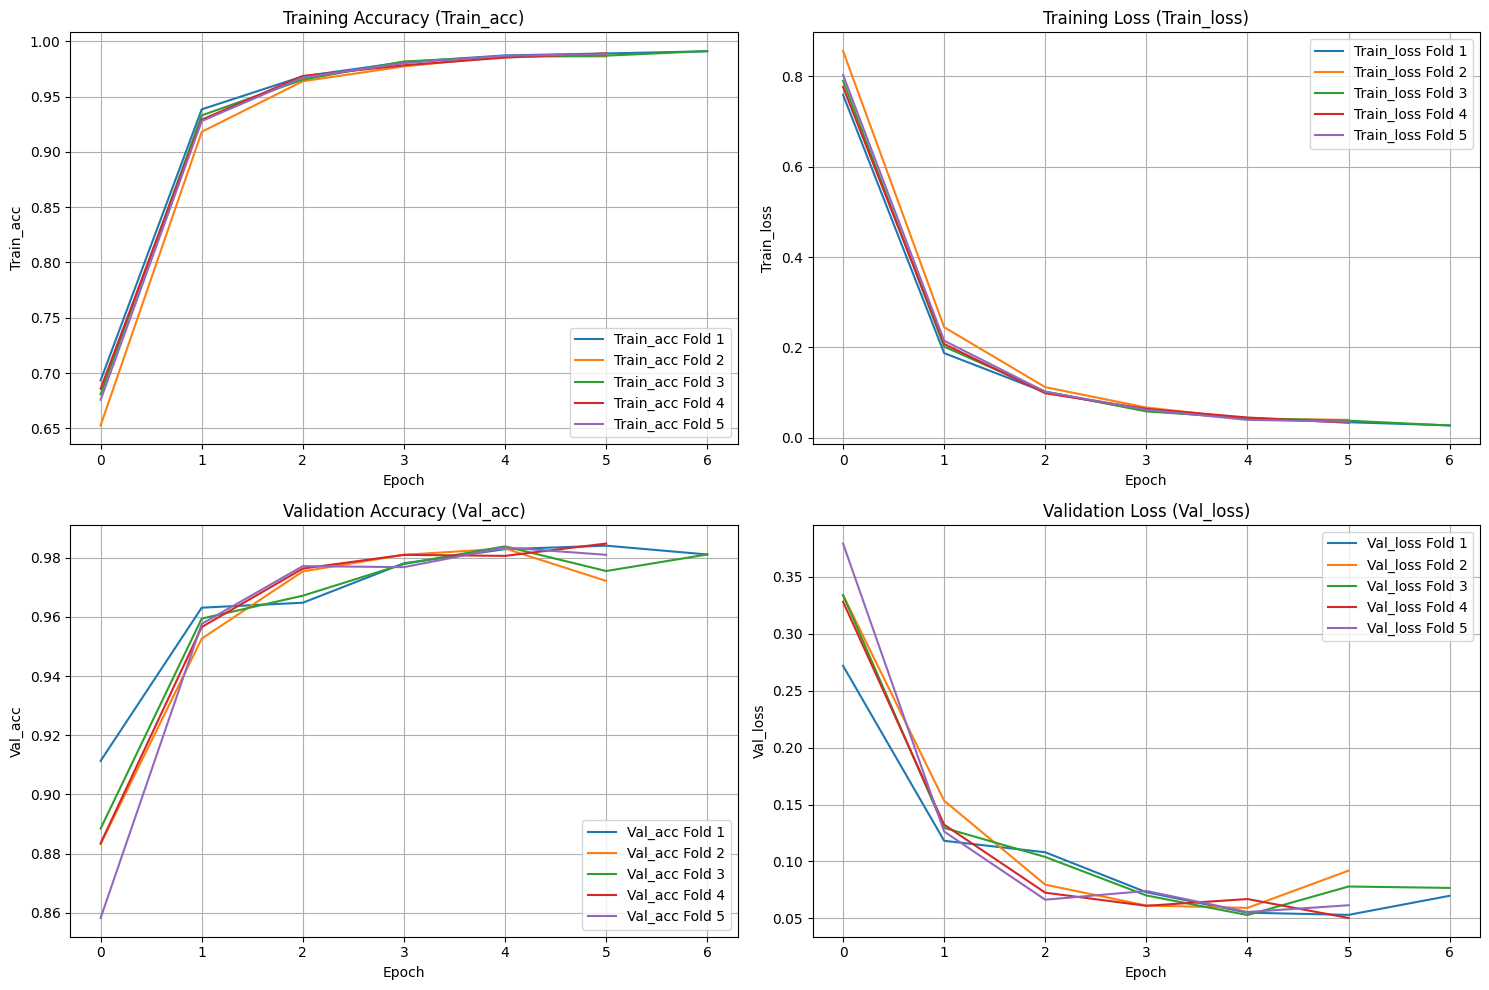

Summary for AlexNet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]          23,296
              ReLU-2           [-1, 64, 31, 31]               0
         MaxPool2d-3           [-1, 64, 15, 15]               0
            Conv2d-4          [-1, 192, 15, 15]         307,392
              ReLU-5          [-1, 192, 15, 15]               0
         MaxPool2d-6            [-1, 192, 7, 7]               0
            Conv2d-7            [-1, 384, 7, 7]         663,936
              ReLU-8            [-1, 384, 7, 7]               0
            Conv2d-9            [-1, 256, 7, 7]         884,992
             ReLU-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]         590,080
             ReLU-12            [-1, 256, 7, 7]               0
        MaxPool2d-13            [-1, 256, 3, 3]               0
AdaptiveAvgPool2d-1

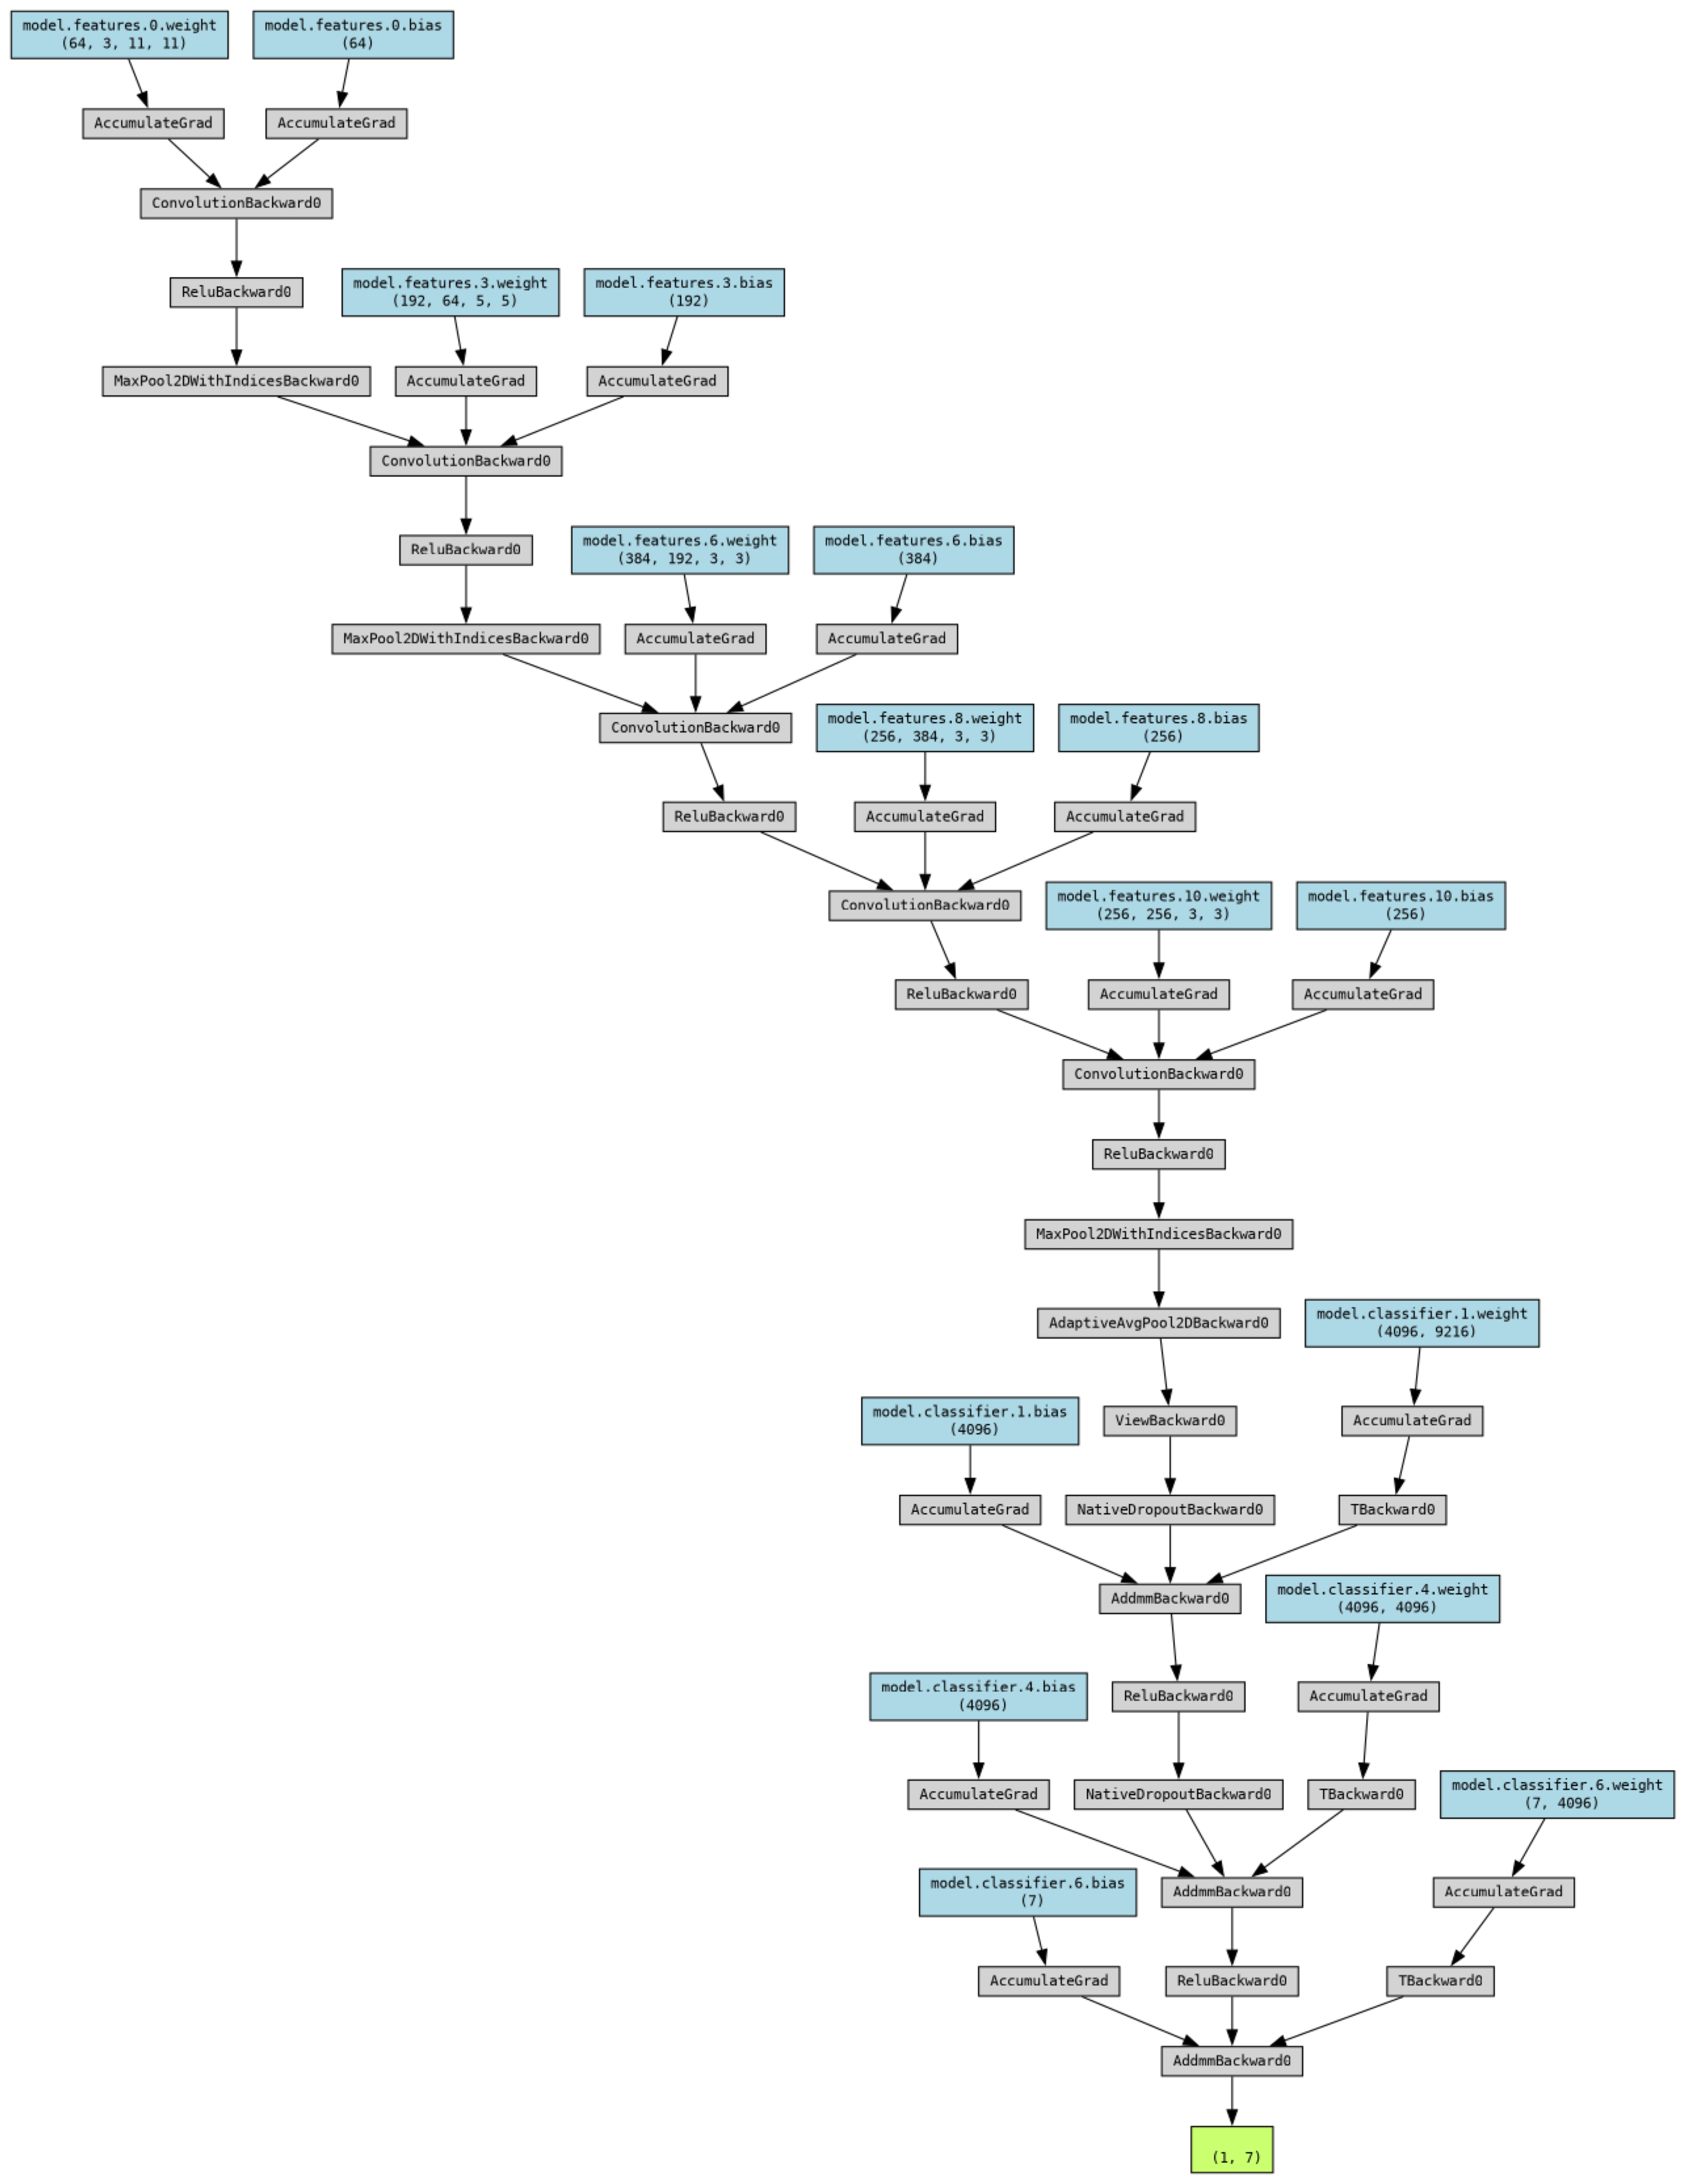

In [117]:
# DatasetFromTensors - Definicja klasy
class DatasetFromTensors(Dataset):
    def __init__(self, images_tensor, labels_tensor):
        self.images_tensor = images_tensor
        self.labels_tensor = labels_tensor

    def __len__(self):
        return len(self.labels_tensor)

    def __getitem__(self, idx):
        return self.images_tensor[idx], self.labels_tensor[idx]

# EarlyStopping - Definicja klasy
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_val_acc = 0

    def __call__(self, val_acc, model, path='checkpoint_alexnet.pt'):
        if self.best_score is None:
            self.best_score = val_acc
            self.save_checkpoint(val_acc, model, path)
        elif val_acc < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.save_checkpoint(val_acc, model, path)
            self.counter = 0

    def save_checkpoint(self, val_acc, model, path):
        self.best_val_acc = val_acc
        torch.save(model.state_dict(), path)

# Funkcja do trenowania i ewaluacji modelu
def train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, device, epochs, patience):
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    early_stopping = EarlyStopping(patience=patience, delta=0.01)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_acc = correct / total
        train_loss = running_loss / len(train_loader)
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        val_loss = running_loss / len(val_loader)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        early_stopping(val_acc, model, path='checkpoint_alexnet.pt')

        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    return history, early_stopping.best_val_acc

# Definicja modelu AlexNet bez załadowanych wag
class AlexNetModel(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetModel, self).__init__()
        self.model = models.alexnet(weights=None)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Inicjalizacja modelu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_name_dict)
alexnet_histories = []
alexnet_times = []

print("Training AlexNet model...")
epochs = 50 
patience = 3  
lr = 0.0001
batch_size = 64

labels = np.array(train_sampled['Group'].astype(int))

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, val_index) in enumerate(kf.split(np.zeros(len(labels)), labels), 1):
    print(f"Fold {fold}/5")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    train_loader = DataLoader(DatasetFromTensors(train_images_tensor, train_labels_tensor), batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(DatasetFromTensors(train_images_tensor, train_labels_tensor), batch_size=batch_size, sampler=val_sampler)

    model = AlexNetModel(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    start_time = time.time()
    history, best_val_acc = train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, device, epochs, patience)
    end_time = time.time()
    
    alexnet_histories.append(history)
    alexnet_times.append(end_time - start_time)
    
    print(f"Best validation accuracy for fold {fold}: {best_val_acc:.4f}")

print("Training completed for AlexNet model with early stopping.")

# Rysowanie wykresów krzywych uczenia
metrics = ['train_acc', 'train_loss', 'val_acc', 'val_loss']
titles = ['Training Accuracy', 'Training Loss', 'Validation Accuracy', 'Validation Loss']
plot_learning_curves(alexnet_histories, metrics, titles)

# Generowanie podsumowania i wizualizacji modelu
alexnet_model = AlexNetModel(num_classes=num_classes).to(device)
print("Summary for AlexNet")
summary(alexnet_model, input_size=(3, 128, 128))

# Przykładowe dane wejściowe
x = torch.randn(1, 3, 128, 128).to(device)

# Forward pass przez model
y = alexnet_model(x)

# Wizualizacja modelu w większym rozmiarze
make_dot(y, params=dict(alexnet_model.named_parameters())).render("alexnet_model_large", format="png")

# Wyświetlenie obrazu schematu modelu w większym rozmiarze
image = Image.open("alexnet_model_large.png")
plt.figure(figsize=(50, 50))  # Zmienione na większy rozmiar
plt.imshow(image)
plt.axis('off')
plt.show()

Hiperparametry:

* Learning Rate (lr): 0.0001
* Epochs: 50
* Batch Size: 64
* Optimizer: Adam
* Loss Function: CrossEntropyLoss
* Patience: 3 (Early Stopping)

Cross-Walidacja: K=5

Early Stopping: Mechanizm zatrzymujący trening, jeśli model przestaje się poprawiać na zbiorze walidacyjnym przez określoną liczbę epok (patience).

Test Accuracy: 0.9330, Test Loss: 0.2070


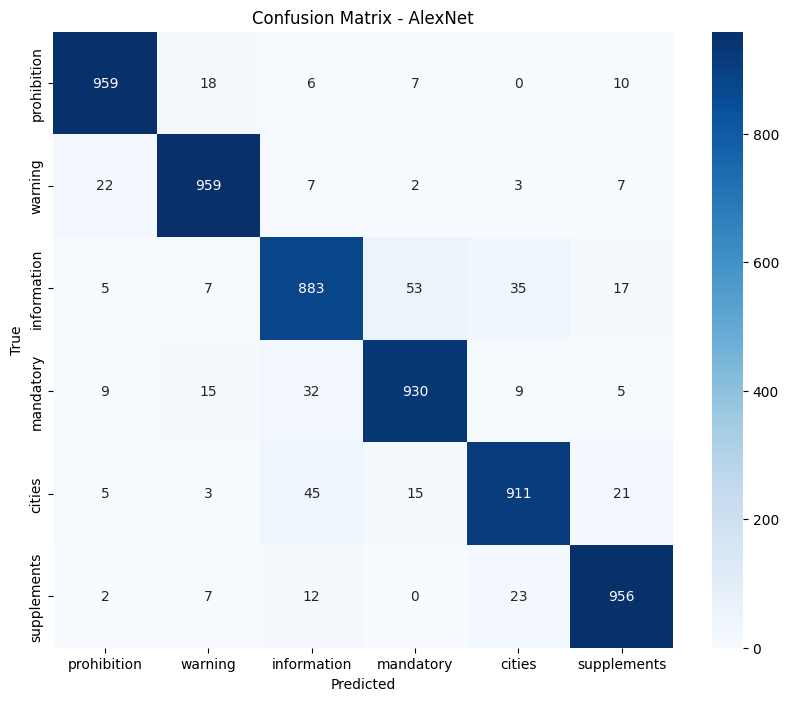

In [119]:
# Funkcja do ewaluacji modelu na zbiorze testowym
def evaluate_on_test(model, criterion, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    test_acc = correct / total
    test_loss = running_loss / len(test_loader)
    
    cm = confusion_matrix(all_labels, all_predictions)
    
    return test_acc, test_loss, cm

# Tworzenie DataLoadera dla zbioru testowego
test_loader = DataLoader(DatasetFromTensors(test_images_tensor, test_labels_tensor), batch_size=32, shuffle=False)

# Ładowanie najlepszego modelu AlexNet
best_alexnet_model = AlexNetModel(num_classes=len(class_name_dict)).to(device)
best_alexnet_model.load_state_dict(torch.load('checkpoint_alexnet.pt'))

# Ewaluacja modelu na zbiorze testowym
test_acc, test_loss, cm = evaluate_on_test(best_alexnet_model, nn.CrossEntropyLoss(), test_loader, device)
print(f'Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

# Wyświetlenie macierzy pomyłek
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_name_dict[str(i)] for i in sorted(set(test_labels_tensor.cpu().numpy()))], yticklabels=[class_name_dict[str(i)] for i in sorted(set(test_labels_tensor.cpu().numpy()))])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - AlexNet')
plt.show()

# Porównanie modeli: ResNet18, VGG16, AlexNet

ResNet18 - Test Accuracy: 0.9280, Test Loss: 0.2325
VGG16 - Test Accuracy: 0.9343, Test Loss: 0.2238
AlexNet - Test Accuracy: 0.9330, Test Loss: 0.2070


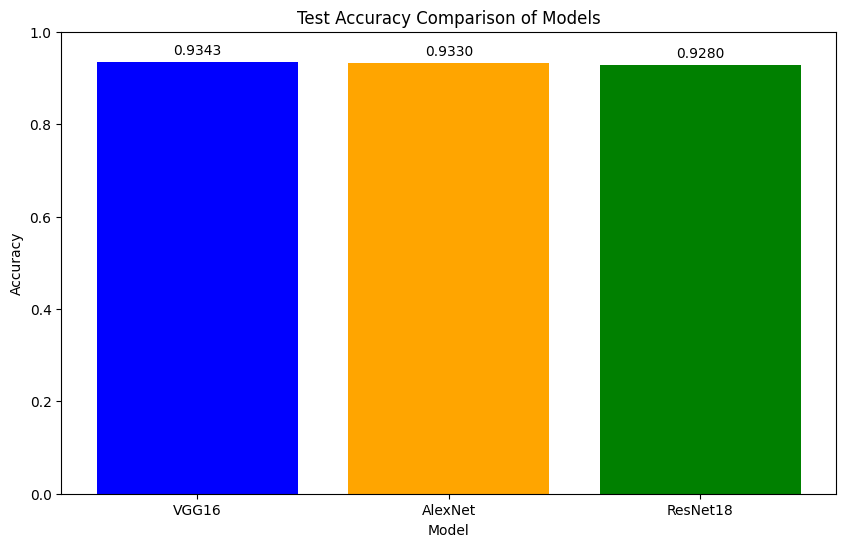

In [126]:
# Funkcja do ewaluacji modelu na zbiorze testowym
def evaluate_on_test(model, criterion, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    test_acc = correct / total
    test_loss = running_loss / len(test_loader)
    
    return test_acc, test_loss

# Tworzenie DataLoadera dla zbioru testowego
test_loader = DataLoader(DatasetFromTensors(test_images_tensor, test_labels_tensor), batch_size=32, shuffle=False)

# Inicjalizacja modeli
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_name_dict)

class ResNet18Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18Model, self).__init__()
        self.model = models.resnet18(weights=None)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

class VGG16Model(nn.Module):
    def __init__(self, num_classes):
        super(VGG16Model, self).__init__()
        self.model = models.vgg16(weights=None)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

class AlexNetModel(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetModel, self).__init__()
        self.model = models.alexnet(weights=None)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Ścieżki do checkpointów
checkpoint_paths = {
    'ResNet18': '/kaggle/working/checkpoint_ResNet18.pt',
    'VGG16': '/kaggle/working/checkpoint_vgg16.pt',
    'AlexNet': '/kaggle/working/checkpoint_alexnet.pt'
}

# Ładowanie modeli i ewaluacja na zbiorze testowym
models = {
    'ResNet18': ResNet18Model(num_classes=num_classes),
    'VGG16': VGG16Model(num_classes=num_classes),
    'AlexNet': AlexNetModel(num_classes=num_classes)
}

results = []

for model_name, model in models.items():
    model.load_state_dict(torch.load(checkpoint_paths[model_name]))
    model = model.to(device)
    test_acc, test_loss = evaluate_on_test(model, nn.CrossEntropyLoss(), test_loader, device)
    results.append((model_name, test_acc))
    print(f'{model_name} - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

# Sortowanie wyników według dokładności
results.sort(key=lambda x: x[1], reverse=True)

# Tworzenie wykresu słupkowego
model_names, accuracies = zip(*results)
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison of Models')
plt.ylim(0, 1)  # Zakres od 0 do 1 dla osi Y

# Dodanie wartości dokładności nad słupkami
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{acc:.4f}', ha='center', va='bottom')

plt.show()